In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html


In [4]:
######################################################################################################
#  ________   _________   ___    ___ ___  ___  ________  ________  ___  __      _______   _______
# |\   ___  \|\___   ___\|\  \  /  /|\  \|\  \|\   __  \|\   ____\|\  \|\  \   /  ___  \ /  ___  \
# \ \  \\ \  \|___ \  \_|\ \  \/  / | \  \\\  \ \  \|\  \ \  \___|\ \  \/  /|_/__/|_/  //__/|_/  /|
#  \ \  \\ \  \   \ \  \  \ \    / / \ \   __  \ \   __  \ \  \    \ \   ___  \__|//  / /__|//  / /
#   \ \  \\ \  \   \ \  \  /     \/   \ \  \ \  \ \  \ \  \ \  \____\ \  \\ \  \  /  /_/__  /  /_/__
#    \ \__\\ \__\   \ \__\/  /\   \    \ \__\ \__\ \__\ \__\ \_______\ \__\\ \__\|\________\\________\
#     \|__| \|__|    \|__/__/ /\ __\    \|__|\|__|\|__|\|__|\|_______|\|__| \|__| \|_______|\|_______|
#                        |__|/ \|__|
######################################################################################################

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
from torch.utils.data import Dataset, DataLoader
from mne.decoding import Vectorizer
torch.manual_seed(42)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [6]:
# Path to training data
train_path = "/content/gdrive/My Drive/codalab/training/"

In [7]:
# Path to testing data (public test set)
test_path = "/content/gdrive/My Drive/codalab/testing_flat/"

In [8]:
condition_ec = "EC"  # closed eyes condition
condition_eo = "EO"  # closed eyes condition
train_subj = 1100  # use 1100 of the 1200 training subjects for training
val_subj = 100   # use 100 of the 1200 training subjects for validation
test_subj = 400  # use 10 instead of 400 testing subjects, for demonstration purpose

In [9]:
fName = f"subj{1098:04}_{condition_eo}_raw.fif.gz"
raw = mne.io.read_raw(train_path + fName, preload=True, verbose='warning')

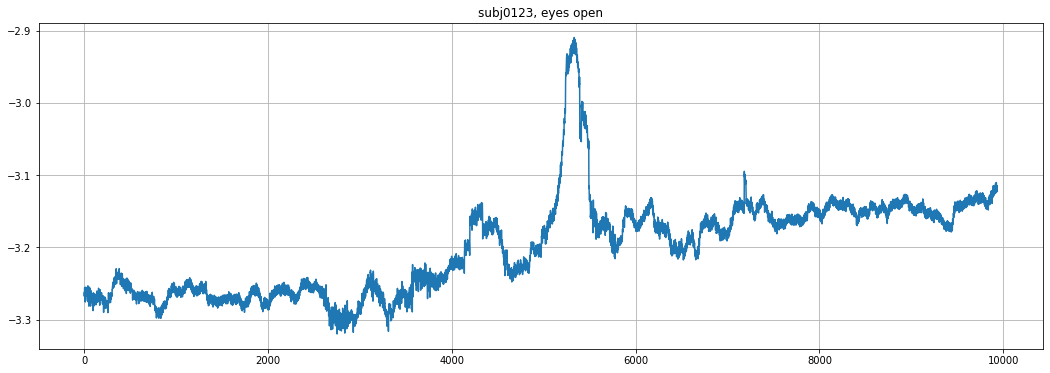

In [10]:
plt.figure(figsize=(18, 6))
plt.plot(200*raw.get_data('E48')[0][:-49])
plt.title('subj0123, eyes open')
plt.grid(True)
plt.show()
plt.close()

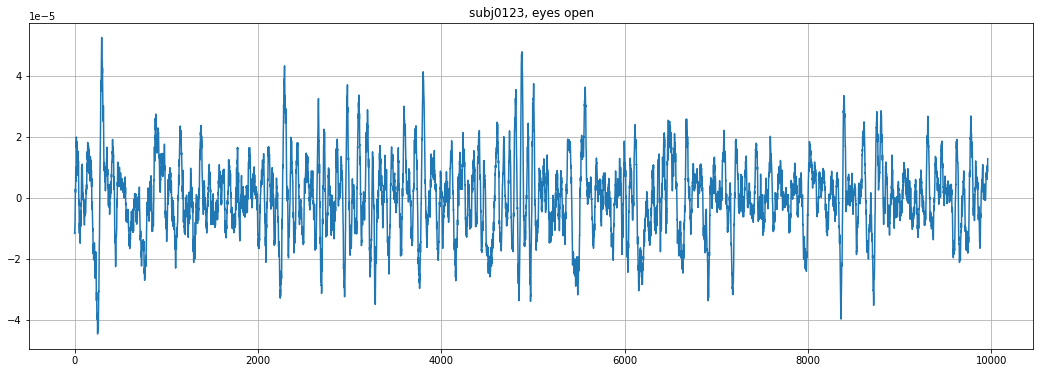

In [11]:
plt.figure(figsize=(18, 6))
a = raw.get_data('E5')[0][:-25] - raw.get_data('E5')[0][25:]
plt.plot(a)
plt.title('subj0123, eyes open')
plt.grid(True)
plt.show()
plt.close()

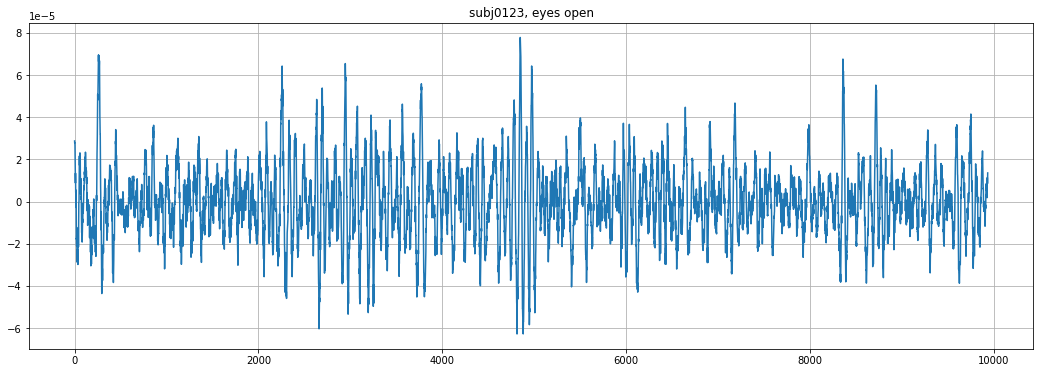

In [12]:
plt.figure(figsize=(18, 6))
plt.plot(a[25:] - a[:-25])
plt.title('subj0123, eyes open')
plt.grid(True)
plt.show()
plt.close()

In [13]:
class CustomDataset(Dataset):
    def __init__(self, path, subj, ages, start):
        self.path = path
        self.subj = subj
        self.ages = ages
        self.start = start
    def __len__(self):
        return self.subj
    def __getitem__(self, idx):
        s = idx + self.start
        fname = f"subj{s:04}_{condition_eo}_raw.fif.gz"
        raw = mne.io.read_raw(self.path + fname, preload=True, verbose='warning')
        d = raw.get_data()
        ft = d.shape[-1]
        data_eo = torch.zeros(1, 129, 10000)
        data_eo[:, :, :ft] = -200 * torch.tensor(d)
        fname = f"subj{s:04}_{condition_ec}_raw.fif.gz"
        raw = mne.io.read_raw(self.path + fname, preload=True, verbose='warning')
        d = raw.get_data()
        ft = d.shape[-1]
        data_ec = torch.zeros(1, 129, 20000)
        data_ec[:, :, :ft] = -200 * torch.tensor(d)
        data = (data_eo, data_ec)
        age = self.ages[idx]
        return data, age

In [14]:
# get the age to predict from the CSV file
meta = pd.read_csv(train_path + "train_subjects.csv")
y_train = []
for age in meta.age[:1200]:
    y_train.append(age)
print(np.min(y_train), np.mean(y_train), np.median(y_train), np.max(y_train))

5.005932 10.356727775833333 9.587952999999999 21.899041


In [15]:
train_data = CustomDataset(train_path, train_subj, y_train[:train_subj], 1)

In [16]:
val_data = CustomDataset(train_path, val_subj, y_train[train_subj:train_subj+val_subj], 1 + train_subj)

In [17]:
# DataLoader
batch_size = 16

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=1
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    num_workers=1
)

In [18]:
e = torch.ones(4,5)
e[2,2] = 9.3
np.around(e).int()

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 9, 1, 1],
        [1, 1, 1, 1, 1]], dtype=torch.int32)

In [19]:
class AgeNET(nn.Module):
    def conv_block(self, in_channels, out_channels, kernel, stride, pool):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel, stride=stride, padding=0),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(1, pool), stride=(1, pool))
        )
    def __init__(self, out_len, state, sampling_rate, num_T, num_C):
        super().__init__()
        self.device = torch.device(DEVICE)
        self.pool = 3
        self.state = state
        self.Time1_eo = self.conv_block(1, num_T, (1, sampling_rate//2), 1, self.pool*4)
        self.Time2_eo = self.conv_block(1, num_T, (1, sampling_rate//4), 1, self.pool*4)
        self.Time3_eo = self.conv_block(1, num_T, (1, sampling_rate//8), 1, self.pool*4)
        self.Time1_ec = self.conv_block(1, num_T, (1, sampling_rate//2), 1, self.pool*4)
        self.Time2_ec = self.conv_block(1, num_T, (1, sampling_rate//4), 1, self.pool*4)
        self.Time3_ec = self.conv_block(1, num_T, (1, sampling_rate//8), 1, self.pool*4)
        self.BN_T_eo = nn.BatchNorm2d(num_T)
        self.BN_T_ec = nn.BatchNorm2d(num_T)
        self.Chan1_eo = self.conv_block(num_T, num_C, (129, 1), 1, self.pool)
        self.Chan2_eo = self.conv_block(num_T, num_C, (65, 1), (64, 1), self.pool)
        self.Chan1_ec = self.conv_block(num_T, num_C, (129, 1), 1, self.pool)
        self.Chan2_ec = self.conv_block(num_T, num_C, (65, 1), (64, 1), self.pool)
        self.BN_C_eo = nn.BatchNorm2d(num_C)
        self.BN_C_ec = nn.BatchNorm2d(num_C)
        size_eo, size_ec = self.get_size()
        print(size_eo, size_ec)
        self.fc_eo = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=size_eo, out_features=8192, bias=True),
            nn.BatchNorm1d(8192),
            nn.ReLU()
        )
        self.fc_ec = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=size_ec, out_features=8192, bias=True),
            nn.BatchNorm1d(8192),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=16384, out_features=4096, bias=True),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p=0.01, inplace=False),
            nn.Linear(in_features=4096, out_features=2048, bias=True),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.003, inplace=False),
            nn.Linear(in_features=2048, out_features=1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.002, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.001, inplace=False),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64, bias=True),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.last_layer = []
        for j in out_len:
            self.last_layer.append(
                nn.Sequential(
                    nn.Linear(in_features=64, out_features=j, bias=True),
                    nn.ReLU()
                )
            )
    def forward(self, x_eo, x_ec):
        y = self.Time1_eo(x_eo)
        out_eo = y
        y = self.Time2_eo(x_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time3_eo(x_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time1_ec(x_ec)
        out_ec = y
        y = self.Time2_ec(x_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        y = self.Time3_ec(x_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        out_eo = self.BN_T_eo(out_eo)
        out_ec = self.BN_T_ec(out_ec)
        z = self.Chan1_eo(out_eo)
        out_f_eo = z
        z = self.Chan2_eo(out_eo)
        out_f_eo = torch.cat((out_f_eo, z), dim=2)
        z = self.Chan1_ec(out_ec)
        out_f_ec = z
        z = self.Chan2_ec(out_ec)
        out_f_ec = torch.cat((out_f_ec, z), dim=2)
        out = torch.cat((self.fc_eo(out_f_eo), self.fc_ec(out_f_ec)), dim=-1)
        out = self.classifier(out)
        out = self.last_layer[self.state]
        return out
    def set_state(self, st):
        self.state = st
    def get_size(self):
        d_eo = torch.ones(1, 1, 129, 10000)
        d_ec = torch.ones(1, 1, 129, 20000)
        y = self.Time1_eo(d_eo)
        out_eo = y
        y = self.Time2_eo(d_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time3_eo(d_eo)
        out_eo = torch.cat((out_eo, y), dim=-1)
        y = self.Time1_ec(d_ec)
        out_ec = y
        y = self.Time2_ec(d_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        y = self.Time3_ec(d_ec)
        out_ec = torch.cat((out_ec, y), dim=-1)
        out_eo = self.BN_T_eo(out_eo)
        out_ec = self.BN_T_ec(out_ec)
        z = self.Chan1_eo(out_eo)
        out_f_eo = z
        z = self.Chan2_eo(out_eo)
        out_f_eo = torch.cat((out_f_eo, z), dim=2)
        z = self.Chan1_ec(out_ec)
        out_f_ec = z
        z = self.Chan2_ec(out_ec)
        out_f_ec = torch.cat((out_f_ec, z), dim=2)
        return torch.numel(out_f_eo), torch.numel(out_f_ec)

In [20]:
model_A = AgeNET([25, 1], 0, 256, 9, 6)
model_A = model_A.to(DEVICE)

14868 29880


In [21]:
from torchsummary import summary

summary(model_A, [(1, 129, 10000), (1, 129, 20000)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 9, 129, 9873]           1,161
         LeakyReLU-2         [-1, 9, 129, 9873]               0
         AvgPool2d-3          [-1, 9, 129, 822]               0
            Conv2d-4         [-1, 9, 129, 9937]             585
         LeakyReLU-5         [-1, 9, 129, 9937]               0
         AvgPool2d-6          [-1, 9, 129, 828]               0
            Conv2d-7         [-1, 9, 129, 9969]             297
         LeakyReLU-8         [-1, 9, 129, 9969]               0
         AvgPool2d-9          [-1, 9, 129, 830]               0
           Conv2d-10        [-1, 9, 129, 19873]           1,161
        LeakyReLU-11        [-1, 9, 129, 19873]               0
        AvgPool2d-12         [-1, 9, 129, 1656]               0
           Conv2d-13        [-1, 9, 129, 19937]             585
        LeakyReLU-14        [-1, 9, 129

In [22]:
def train(model, device, train_loader, val_loader, lr, epochs):
    train_abs_log = []
    train_log = []
    val_log = []
    val_abs_log = []
    model.train()
    abs_loss = nn.L1Loss(reduction='mean')
    lossfunc = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
    f = plt.figure()
    for epoch in range(epochs):
        plt.clf()
        train_abs_loss = 0.0
        train_loss = 0.0
        print(f"Epoch #{1 + epoch:02}: ")
        for data, age in train_loader:
            data_eo, data_ec = data
            data_eo = data_eo.to(device)           # shape = (batch_size, 1, 129, 10000)
            data_ec = data_ec.to(device)           # shape = (batch_size, 1, 129, 20000)
            age = age.to(device)               # shape = (batch_size,)
            batch_size = age.size(0)
            optimizer.zero_grad()
            output = model(data_eo, data_ec)       # shape = (batch_size, 25)
            loss = lossfunc(output, np.around(age).int())
            loss.backward()
            optimizer.step()

            train_abs_loss += abs_loss(torch.argmax(output, dim=-1), age).item() * batch_size
            train_loss += loss.item() * batch_size
        train_abs_loss /= train_subj
        train_loss /= train_subj
        train_abs_log.append(train_abs_loss)
        train_log.append(train_loss)
        val_abs_loss = 0.0
        val_loss=0.0
        for data, age in val_loader:
            data_eo, data_ec = data
            data_eo = data_eo.to(device)           # shape = (batch_size, 129, 10000)
            data_ec = data_ec.to(device)           # shape = (batch_size, 129, 20000)
            age = age.to(device)               # shape = (batch_size,)
            batch_size = age.size(0)
            output = model(data_eo, data_ec)       # shape = (batch_size, 25)
            loss = lossfunc(output, np.around(age).int())

            val_abs_loss += abs_loss(torch.argmax(output, dim=-1), age).item() * batch_size
            val_loss += loss.item() * batch_size
        val_abs_loss /= val_subj
        val_loss /= val_subj
        val_abs_log.append(val_abs_loss)
        val_log.append(val_loss)
        print(f"CrossEntropyLoss:     train = {train_loss}, validation = {val_loss}")
        print(f"mean absolute error:  train = {train_abs_loss}, validation = {val_abs_loss}")
        plt.plot(train_log, label='train loss')
        plt.plot(val_log, label='validation loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss')
        plt.legend()
        plt.show()
    return train_abs_log, val_abs_log

In [ ]:
train_abs_log, val_abs_log = train(model_A, DEVICE, train_loader, val_loader, 0.008, 30)

Epoch #01: 
